In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv")
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [3]:
df.shape

(253680, 22)

In [4]:
df.isnull().sum()

Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

In [5]:
df.columns

Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [6]:
df = df[df["BMI"] < 60]
df = df[df["BMI"] > 15]

In [7]:
df_binary = df.drop(['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education','Income'], axis="columns")
df_nonBinary = df.filter(items=['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education','Income','Diabetes_012'])


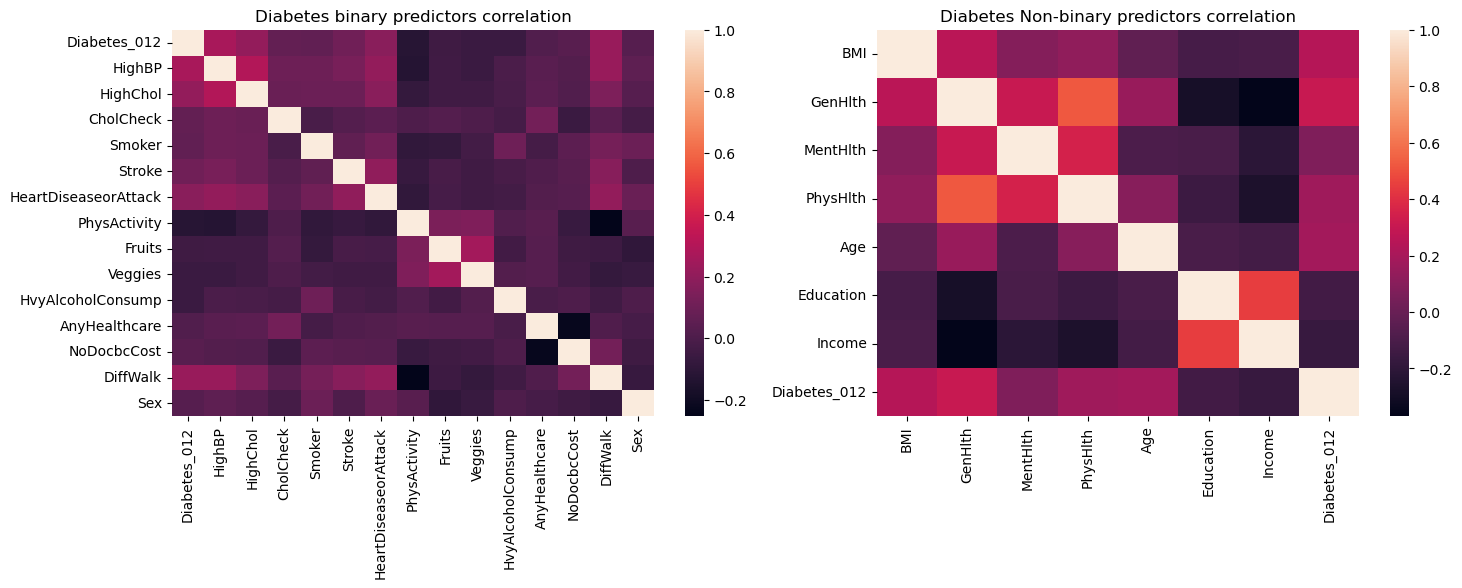

In [8]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.heatmap(df_binary.corr(), annot=False)
plt.title("Diabetes binary predictors correlation")

plt.subplot(2, 2, 2)
sns.heatmap(df_nonBinary.corr(), annot=False)
plt.title("Diabetes Non-binary predictors correlation")

plt.tight_layout() 

Text(0.5, 1.0, 'Diabetes predictors correlation')

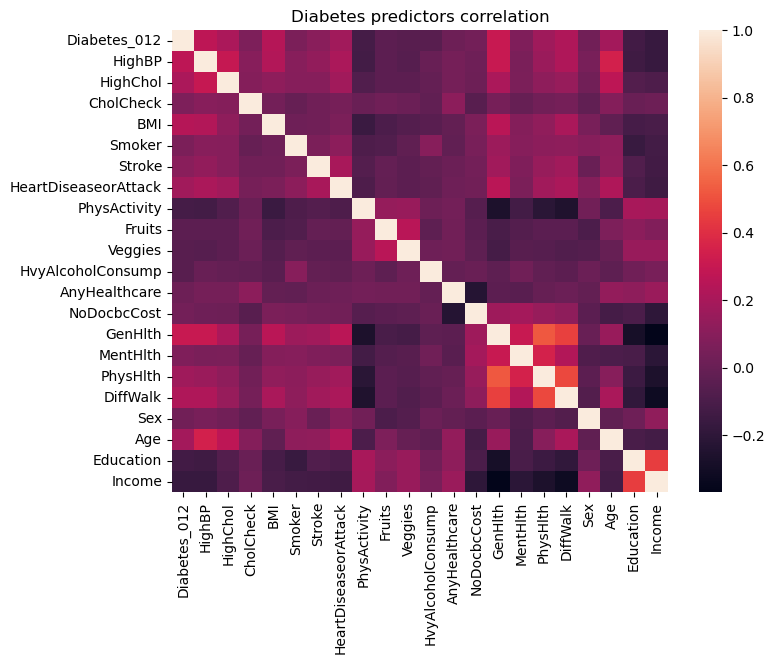

In [9]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=False)
plt.title("Diabetes predictors correlation")

In [10]:
X = df.drop(["Diabetes_012"] ,axis="columns")
y = df.filter(["Diabetes_012"])

In [11]:
from sklearn.model_selection import train_test_split, KFold,cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
kfolds = KFold(n_splits=3, shuffle=True, random_state=42)

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)



In [13]:
def cv_rmse(model, X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return rmse

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'KNeighborsClassifier' : {
            'model': KNeighborsClassifier(),
            'params': {
                'algorithm': ['ball_tree', 'auto', 'kd_tree']
            }
        },
        'SVM': {
            'model': SVC(),
            'params': {
                'C': [1e-4, 0.001, 1, 1000],
                'kernel': ['linear', 'poly', 'rbf']
            }
        },
        'decision_tree': {
            'model': DecisionTreeClassifier(),
            'params': {
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    kfolds = KFold(n_splits=5, shuffle=True, random_state=99)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=kfolds, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

In [14]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

logRegression = LogisticRegressionCV(max_iter=10000)
logRegression.fit(X_train,y_train.values.ravel())
logRegression.score(X_test,y_test.values.ravel())

0.8474952002058468

In [15]:
from sklearn.svm import SVC

svc = SVC(C=0.001,kernel='linear')
svc.fit(X_train, y_train.values.ravel())
svc.score(X_test,y_test.values.ravel())

0.8422302713615581

In [16]:
from sklearn.neighbors import KNeighborsClassifier
kNeighbours = KNeighborsClassifier(weights='distance')
kNeighbours.fit(X_train, y_train.values.ravel())
kNeighbours.score(X_test,y_test.values.ravel())

0.8219820675731845

In [17]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(splitter='best')
decision_tree.fit(X_train, y_train.values.ravel())
decision_tree.score(X_test,y_test.values.ravel())

0.7673732755378738

In [21]:
from datetime import datetime

lrscore = cv_rmse(logRegression, X_train, y_train.values.ravel())
print("LogisticRegression: ({})\n mean {:.5f}\n std: {:.5f}".format(datetime.now(),lrscore.mean(), lrscore.std()))

kNeighbourscore = cv_rmse(kNeighbours, X_train, y_train.values.ravel())
print("KNearestNeighbour: ({})\n mean {:.5f}\n std: {:.5f}".format(datetime.now(),kNeighbourscore.mean(), kNeighbourscore.std()))

svcscore = cv_rmse(svc, X_train, y_train.values.ravel())
print("Support Vector Classification: ({})\n mean {:.5f}\n std: {:.5f}".format(datetime.now(),svcscore.mean(), svcscore.std()))

decisionTreeScore = cv_rmse(decision_tree, X_train, y_train.values.ravel())
print("Decision Tree: ({})\n mean {:.5f}\n std: {:.5f}".format(datetime.now(),decisionTreeScore.mean(), decisionTreeScore.std()))

LogisticRegression: (2023-08-27 09:11:40.931843)
 mean 0.74327
 std: 0.00289
KNearestNeighbour: (2023-08-27 09:13:42.244438)
 mean 0.80787
 std: 0.00042
Support Vector Classification: (2023-08-27 09:33:35.242218)
 mean 0.75754
 std: 0.00294
Decision Tree: (2023-08-27 09:33:37.452284)
 mean 0.89846
 std: 0.00243


In [19]:
import pickle
with open('diabetes_model.pickle','wb') as f:
    pickle.dump(logRegression,f)